In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpltools import color
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import IOfunctions as iof
from DSH import SALS as LS

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('SALS tutorial started')

INFO:root:SALS tutorial started


# Small Angle Light Scattering (SALS)

```SALS``` class is designed to analyze far-field light scattering experiments in the small-angle configuration, where image pixels map not in different locations of the sample (as in DSH) but in different scattering vectors. A typical speckle field in SALS experiment looks like this:

DEBUG:root:MIfile object created with filename ..\SALS_test\MI_SLS2.raw
DEBUG:root:MIfile - Metadata filename automatically generated: ..\SALS_test\MI_SLS2_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: ..\SALS_test\MI_SLS2_metadata.ini)
DEBUG:root:Loading config file ..\SALS_test\MI_SLS2_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


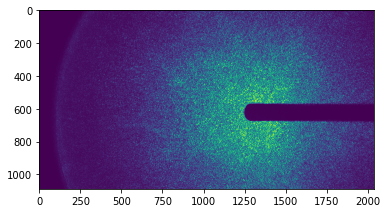

In [2]:
froot = r'..\SALS_test'
MIinput = MI.MIfile(os.path.join(froot, 'MI_SLS2.raw'))
MIinput.OpenForReading()
plt.imshow(MIinput.GetImage(0))

A ```SALS``` object inherits from ```ROIproc```, the generic ROI-processing class. It works with polar coordinates and has specific functions for background correction. To initialize ```SALS```:

```python
SALS_analyzer = LS.SALS(MIinput, centerPos, ROIslices=None, maskRaw=None, imgTimes=None, expTimes=[1], PDdata=None, BkgCorr=None)
```

where:

- ```MIinput``` contains the input images, and can be either a ```MIfile``` or a ```MIstack```
- ```centerPos``` defines the coordinates ```[x, y]``` of the transmitted beam position, in pixels, relative to top-left corner
- ```ROIslices=[rSlices, aSlices]``` defines the regions of interest (ROIs) of the analysis
- ```maskRaw``` eventually masks pixels to be excluded from the analysis
- ```imgTimes``` is the list of image times, especially important if images were not acquired at constant FPS
- ```expTimes``` is the list of exposure times. With multiple exposure times, ```SALS``` assumes that images in ```MIinput``` cycle through exposure times
- ```PDdata=[Iin, Itr]``` eventually contains photodiode data monitoring incoming and transmitted intensities for each image
- ```BkgCorr=[DarkBkg, OptBkg, BkgPDdata]``` contains data for background correction

An empty ```SALS``` object can be initialized by specifying just the input ```MIfile``` and ```centerPos```:

In [3]:
SLS_ctrPos = [1303, 624]
SALS_analyzer = LS.SALS(MIinput, centerPos=SLS_ctrPos)
print(SALS_analyzer)

DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 1 valid ROIs
DEBUG:root:85 image times automatically generated from MI metadata (fps=0.25Hz)
DEBUG:root:Set one single exposure time: 1
DEBUG:root:MaskCoords created with
	- 1 first coords from 1156.50 (+- 1155.50) to 1156.50 (+- 1155.50) and
	- 1 second coords from 0.0 (+- 3.15) to 0.00 (+- 3.15)
DEBUG:root:1 binary masks created with shape (1088, 2040)
DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 1 valid ROIs



|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (..\SALS_test\MI_SLS2.raw), 85 images
| Center position : [1303, 624]
| ROIs            : 1 (1 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


### ROI definition
The speckle intensity here is not homogeneous as in DSH, but increases moving towards a point, which is the location where the transmitted beam would hit the detector, if there wasn't the black shadow of the beam stop blocking it. The fist step of a SALS analysis, essential to map pixel location in scattering vector (```centerPos```), is to identify the transmitted beam location, and to create a binary mask (```maskRaw```) to exclude from the analysis the pixels shadowed by the beam stop.
By design, ```SALS``` expects that ```centerPos``` is a couple of floats ```(posX, posY)``` specifying the location of the center in pixels, relative to the upper left corner of the image. The upper left corner location is ```(0, 0)```.

Once ```centerPos``` is specified, the analysis can be specialized on annular regions around the center, thereby averaging on scattering vectors of equal magnitude and different azimuthal orientation. 

Azimuthal annuli can be generated using:

```python
ROImasks, ROIcoords = SALS.GenerateROIs(ROI_specs, imgShape, centerPos, maskRaw)
```

where ```ROI_specs=[rSlices, aSlices]```. 

```SALS_analyzer``` can be configured to work with a given set of ROIs by calling the ```SetROImasks``` function inherited from ```ROIproc```:

```python
SALS_analyzer.SetROImasks(self, ROImasks, ROIcoords=None)
```

Equivalently, one can use 

```python
SALS_analyzer.GenerateROIs(ROI_specs, maskRaw=None)
```

DEBUG:root:MaskCoords created with
	- 9 first coords from 59.87 (+- 9.87) to 858.44 (+- 141.56) and
	- 1 second coords from 0.0 (+- 3.15) to 0.00 (+- 3.15)
DEBUG:root:9 binary masks created with shape (1088, 2040)
DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 9 valid ROIs


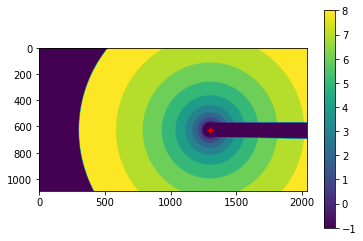

In [4]:
ROI_specs = [np.geomspace(50, 1000, 10), None]
px_mask = MI.ReadBinary(os.path.join(froot, 'MI_SLS2_pxmask.raw'), MIinput.ImageShape(), 'B')
SALS_analyzer.GenerateROIs(ROI_specs, px_mask)

plt.imshow(SALS_analyzer.ROIs)
plt.plot(*SALS_analyzer.centerPos, 'r+')
plt.colorbar()

ROI coordinates are stored in ```SALS_analyzer.ROIcoords```:

Text(0, 0.5, 'theta[rad]')

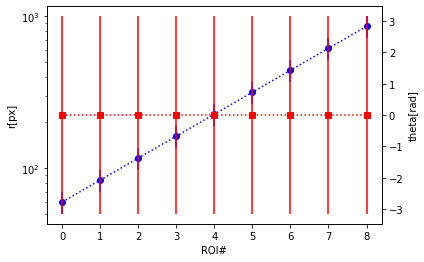

In [5]:
fig, ax = plt.subplots()
ax.errorbar(range(SALS_analyzer.ROIcoords.shape[0]), SALS_analyzer.ROIcoords[:,0], yerr=SALS_analyzer.ROIcoords[:,2]/2, fmt='bo:')
ax2 = ax.twinx()
ax2.errorbar(range(SALS_analyzer.ROIcoords.shape[0]), SALS_analyzer.ROIcoords[:,1], yerr=SALS_analyzer.ROIcoords[:,3]/2, fmt='rs:')
ax.set_yscale('log')
ax.set_ylabel(SALS_analyzer.ROIcoord_names[0])
ax.set_xlabel('ROI#')
ax2.set_ylabel(SALS_analyzer.ROIcoord_names[1])

To speed up calculation, ```SALS``` inherits from ```ROIproc``` a global bounding box (```SALS_analyzer.CropROIbb```) containing all ROIs, and in addition each ROI has its own bounding box (```SALS_analyzer.ROIboundingBoxes```):

(1088.0, 0.0)

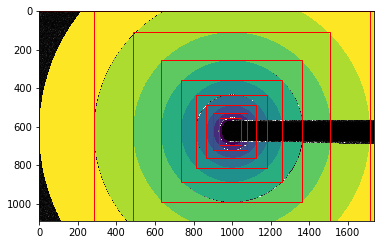

In [6]:
im1_crop = SALS_analyzer.GetImage(0)
fig, ax = plt.subplots()
ax.imshow(im1_crop, interpolation='none', extent=(0, SALS_analyzer.CropROIbb[2], SALS_analyzer.CropROIbb[3], 0), cmap='gray')
for ridx in range(len(SALS_analyzer.ROI_masks_crop)):
    _rbb = SALS_analyzer.ROIboundingBoxes[ridx]
    if SALS_analyzer.ROI_masks_crop is not None:
        ax.imshow(np.where(SALS_analyzer.ROI_masks_crop[ridx],ridx,np.nan), interpolation='none', extent=(_rbb[1], _rbb[3], _rbb[2], _rbb[0]), vmin=0, vmax=len(SALS_analyzer.ROI_masks_crop)-1)
    ax.add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))
ax.set_xlim([0, SALS_analyzer.CropROIbb[2]])
ax.set_ylim([SALS_analyzer.CropROIbb[3], 0])

### Timing and photodiode (PD) data

**Image times**

In typical SALS experiments, images are acquired at a constant rate (FPS), specified in the metadata of each MIfile (see tutorial 1). However, there are cases in which custom acquisition schemes may be used to enhance the sensitivity to both the fastest and the slowest dynamics. In these cases, the time at which each image has beed taken (```imgTimes```) needs to be provided 

**Exposure times**

Because the dynamic range of a typical 8bit camera is not enough to properly measure typical SLS spectra, where the intensity may vary of several orders of magnitude, the same speckle field is typically recorded using multiple exposure times.
Combining images taken at different exposure time in one unique spectrum requires knowledge of the exposure times (```expTimes```). Exposure times can be set with: 

```python
SALS_analyzer.SetExptimes(expTimes)
```

where ```expTimes``` is a sorted list of exposure times

In [7]:
expTimes = np.loadtxt(os.path.join(froot, 'MI_SLS2_imgTimes.dat'), usecols=(2))
SALS_analyzer.SetExptimes(expTimes)
SALS_analyzer.expTimes

DEBUG:root:Set 17 exptimes, sorted from 0.002 to 20.0


array([2.00000e-03, 3.55656e-03, 6.32456e-03, 1.12468e-02, 2.00000e-02,
       3.55656e-02, 6.32456e-02, 1.12468e-01, 2.00000e-01, 3.55656e-01,
       6.32456e-01, 1.12468e+00, 2.00000e+00, 3.55656e+00, 6.32456e+00,
       1.12468e+01, 2.00000e+01])

**NOTE (31/5/2025): exposure time correction**

We noticed that for Basler cameras, a tiny correction on exposure time is needed at the smallest exposure times to obtain the expected trend $\langle I \rangle \propto t_{exp}$. The empirical correction function is: $t_{exp, corr} = t_{exp}(1+dt/t_{exp})$, with $dt=0.01~ms$. This package does NOT implement this correction automatically. To correct exposure times, one has to set the ```ROIproc.ExpTimeCorrFactor``` variable, which is set to 0 by default, to $dt$. You can do this by calling ```SALS_analyzer.SetExptimeCorrFactor(0.01)```:

In [8]:
SALS_analyzer.SetExptimeCorrFactor(0.01)

**PD data**

Intensity can also be corrected by accounting for the time-dependent incoming and transmitted intensities. They can be loaded on the ```SALS``` class by calling ```SALS.LoadPD(PDdata)```, where ```PDdata=[Iin, Itr]``` and both ```Iin``` and ```Itr``` are 1D float arrays containing readings for incoming and transmitted intensity corresponding to each image. If only one is known, the other can be set to ```None```:

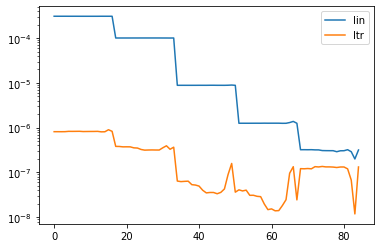

In [9]:
Iin, Itr = np.loadtxt(os.path.join(froot, 'MI_SLS2_imgTimes.dat'), usecols=(9, 10), unpack=True)
SALS_analyzer.LoadPD([Iin, Itr])
fig, ax = plt.subplots()
ax.plot(SALS_analyzer.PDdata[0], label='Iin')
ax.plot(SALS_analyzer.PDdata[1], label='Itr')
ax.set_yscale('log')
ax.legend()

### Background correction

To extract static structure and form factors from static light scattering (SLS), one needs to measure the background contribution to the scattered intensity, and correct for it. This background contribution can have two sources:

- light scattered by imperfections in the optical apparatus
- intensity detected even with the laser switched off (ambient light, dark counts from the camera)

These contributions can be independently estimated by:

- taking images with the laser switched off (```DarkBkg```)
- taking images with the laser switched on, but with the scattering cell filled with a simple liquid with the same refractive index (```OptBkg```)

```SALS``` can take these measurements together with photodiode measurements (```PDdata```) of both the laser intensity and the transmitted intensity, and use this information to correct for the static background. 

*NOTE (9/2/2021): this functionality is still under development*

### SLS analysis

The core of a SALS analysis is to compute ROI-averaged statistics on image intensity $\langle I_p \rangle$ or image correlations $\langle I_p(t) I_p(t+\tau) \rangle$. Refer to ```ROIproc``` tutorial for specific functions to compute ROI-averaged quantities. Static Light Scattering (SLS) assumes that $\langle I_p \rangle$ is measured at different different exposure times. For each ROI, it looks for the exposure time that has the "best" signal, i.e. for which $I_p$ is large enough to minimize the effect of 8bit discretization, yet small enough to avoid overexposure and saturation. In practice, we set an empyrical criterion based on $\langle I_p \rangle$, which should be as large as possible without exceeding a given threshold value set by ```SALS_analyzer.MaxSafeAvgIntensity```:

In [10]:
SALS_analyzer.MaxSafeAvgIntensity

30

This selection is done by the function
```python
ROIavgs_best, BestExptime_Idx = SALS_analyzer.FindBestExptimes(AverageIntensities, normExptime=True)
```

INFO:root:ROIproc.FindBestExptimes: Correcting exposure times with factor dt=0.0100 ms


Text(0, 0.5, '$t_{exp}$')

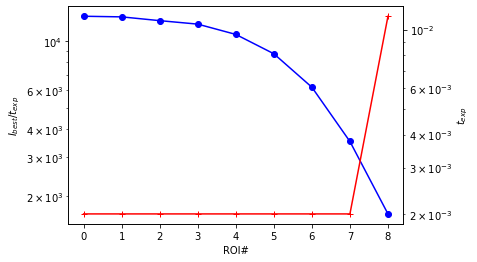

In [11]:
AvgRes = SALS_analyzer.ROIaverageIntensity()
ROIavgs_best, BestExptime_Idx = SALS_analyzer.FindBestExptimes(AvgRes)

fig, ax = plt.subplots()
ax.plot(range(SALS_analyzer.CountROIs()), ROIavgs_best[0], 'bo-')
ax2 = ax.twinx()
ax2.plot(range(SALS_analyzer.CountROIs()), SALS_analyzer.expTimes[BestExptime_Idx[0]], 'r+-')
ax.set_yscale('log')
ax.set_ylabel(r'$I_{best}/t_{exp}$')
ax.set_xlabel('ROI#')
ax2.set_yscale('log')
ax2.set_ylabel(r'$t_{exp}$')

The entire SLS analysis is run by calling
```python
ROIavgs_allExp, ROIavgs_best, BestExptime_Idx, buf_images = SALS_analyzer.doSLS(saveFolder, buf_images=None, no_buffer=False, force_calc=True, norm_PDdata=True, corr_bkg=True)
```

where:
- ```saveFolder``` is the full path of the output folder
- ```buf_images``` can contain an array of images. If provided, the program will use images from the buffer instead of reading it from the input ```MIfile```
- ```no_buffer```: set it to ```True``` to forbid reading all images at once: this slows down the analysis but saves memory
- ```force_calc```: if set to ```False```, the program will look in ```saveFolder``` for previously-computed SLS output. If found, it loads the previously computed results instead of computing it from skratch. If ```force_calc==True```, it computes it even if there is already something in ```saveFolder```.
- ```norm_PDdata```: if set to ```True```, normalize SLS data using ```PDdata```, if available. Regardless, data will still be normalized by the exposure time.
- ```corr_bkg```: if set to ```True```, correct intensities for dark and optical background, if available.

The function returns what is also saved in the result folder:
- ```ROIavgs_allExp```, content of **Iavg_raw.dat**: ROI-averaged image intensity for each input image (one per exposure time, if multiple exposure times are present). Averaged intensity is already normalized by the exposure time, and eventually for photodiode data.
- ```ROIavgs_best```, content of **Iavg.dat**: ROI-averaged optimal image intensity for each input image (obtained selecting the optimal exposure time reported in exptimes.dat). Values in ```ROIavgs_best``` are normalized by the exposure time, and eventually by the photodiode count.
- ```BestExptime_Idx```, content of **exptimes.dat**: optimal exposure time for each ROI and acquired image
- ```buf_images```: buffer of images, eventually filled with images read during SLS analysis

In [12]:
ROIavgs_allExp, ROIavgs_best, BestExptime_Idx, buf_images = SALS_analyzer.doSLS(os.path.join(froot, 'out_SLS_test'))

DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (5, 17, 9)), Iavg data (shape: (5, 9)), exptime data (shape: (5, 9)), buffer images (shape (85, 1088, 1737))


Repeat SALS analysis on optical background:

In [13]:
opt_pre = 'MI_SLS2_Opt'
Opt_MI = MI.MIfile(os.path.join(froot, opt_pre+'.raw'))
Opt_Iin, Opt_Itr = np.loadtxt(os.path.join(froot, opt_pre+'_imgTimes.dat'), usecols=(9, 10), unpack=True)
Opt_SALS = LS.SALS(Opt_MI, centerPos=SLS_ctrPos, ROIslices=ROI_specs, maskRaw=px_mask, 
                   expTimes=np.loadtxt(os.path.join(froot, opt_pre+'_imgTimes.dat'), usecols=(2)), 
                   PDdata=[Opt_Iin, Opt_Itr])
Opt_SALS.SetExptimeCorrFactor(0.01)
Opt_Iavg_raw, Opt_Iavg, Opt_expidx, _ = Opt_SALS.doSLS(os.path.join(froot, 'out_SLS_Opt'))

DEBUG:root:MIfile object created with filename ..\SALS_test\MI_SLS2_Opt.raw
DEBUG:root:MIfile - Metadata filename automatically generated: ..\SALS_test\MI_SLS2_Opt_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: ..\SALS_test\MI_SLS2_Opt_metadata.ini)
DEBUG:root:Loading config file ..\SALS_test\MI_SLS2_Opt_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']
DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 1 valid ROIs
DEBUG:root:17 image times automatically generated from MI metadata (fps=1.0Hz)
DEBUG:root:Set 17 exptimes, sorted from 0.002 to 20.0
DEBUG:root:MaskCoords created with
	- 9 first coords from 59.87 (+- 9.87) to 858.44 (+- 141.56) and
	- 1 second coords from 0.0 (+- 3.15) to 0.00 (+- 3.15)
DEBUG:root:9 binary masks created with shape (1088, 2040)
DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 9 valid ROIs
DEBUG:root:ROIproc.doSLS: output saved
D

Run SALS analysis with background correction

In [14]:
SALS_analyzer.LoadBkg({'Opt' : {'Iavg_raw' : Opt_Iavg_raw, 'Iavg' : Opt_Iavg, 'PDdata' : [Opt_Iin, Opt_Itr]}})
_ = SALS_analyzer.doSLS(os.path.join(froot, 'out_SLS_BkgCorr'))

DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (5, 17, 9)), Iavg data (shape: (5, 9)), exptime data (shape: (5, 9)), buffer images (shape (85, 1088, 1737))


### Open SLS results

A few functions in ```IOfunctions``` make it easier to read these output files (see ```ROIproc``` tutorial for more details about the function):

```python
# To open a generic ASCII file with results:
res_arr[, hdr_list][, firstcol] = IOfunctions.LoadResFile(fname, readHeader=True, isolateFirst=0, delimiter=',', comments='#')

# To open Iavg_raw.dat
Iav, roi_coords, times, exptimes = IOfunctions.OpenRawSLS(fname, roi_numcoords=2, delimiter='\t', comments='#')

# To open Iavg.dat
Iav, roi_coords, times = IOfunctions.OpenSLS(fname, roi_numcoords=2, delimiter='\t', comments='#')
```

Iav_raw.shape  = (18, 5, 17)
Iav.shape  = (18, 5)
roi_coords = [[ 59.87376985  -1.55508836]
 [ 59.87376985   1.55508836]
 [ 83.52096279  -1.55508836]
 [ 83.52096279   1.55508836]
 [116.50763335  -1.55508836]
 [116.50763335   1.55508836]
 [162.52241565  -1.55508836]
 [162.52241565   1.55508836]
 [226.71077275  -1.55508836]
 [226.71077275   1.55508836]
 [316.25037244  -1.55508836]
 [316.25037244   1.55508836]
 [441.15370813  -1.55508836]
 [441.15370813   1.55508836]
 [615.38771542  -1.55508836]
 [615.38771542   1.55508836]
 [858.43558222  -1.55508836]
 [858.43558222   1.55508836]]
times      = [  0.  68. 136. 204. 272.]
exptimes   = [[2.0000e-03 4.0000e-03 6.0000e-03 1.1000e-02 2.0000e-02 3.6000e-02
  6.3000e-02 1.1200e-01 2.0000e-01 3.5600e-01 6.3200e-01 1.1250e+00
  2.0000e+00 3.5570e+00 6.3250e+00 1.1247e+01 2.0000e+01]
 [2.0000e-03 4.0000e-03 6.0000e-03 1.1000e-02 2.0000e-02 3.6000e-02
  6.3000e-02 1.1200e-01 2.0000e-01 3.5600e-01 6.3200e-01 1.1250e+00
  2.0000e+00 3.5570e+00 6.3250e

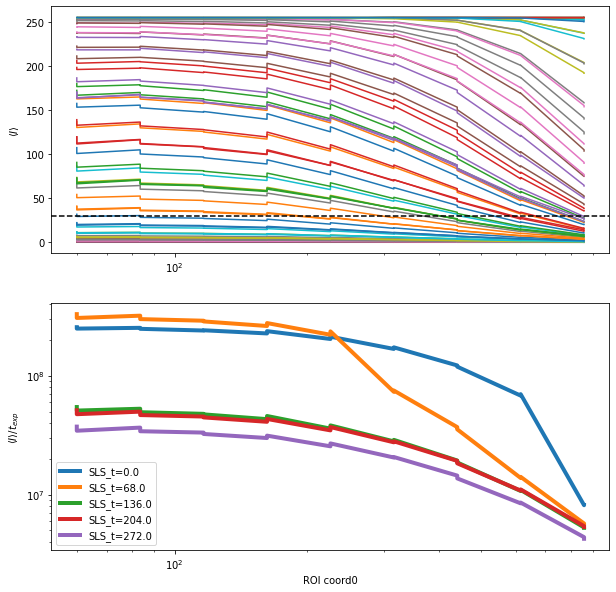

In [15]:
Iav_raw, roi_coords, times, exptimes = iof.OpenRawSLS(os.path.join(froot, 'out_SLS', 'Iavg_raw.dat'), roi_numcoords=2)
Iav, roi_coords, times = iof.OpenSLS(os.path.join(froot, 'out_SLS', 'Iavg.dat'), roi_numcoords=2)
print('Iav_raw.shape  = ' + str(Iav_raw.shape))
print('Iav.shape  = ' + str(Iav.shape))
print('roi_coords = ' + str(roi_coords))
print('times      = ' + str(times))
print('exptimes   = ' + str(exptimes))

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
for t in range(Iav_raw.shape[1]):
    for e in range(Iav_raw.shape[2]):
        ax[0].plot(roi_coords[:,0], Iav_raw[:,t,e])
        #ax[1].plot(roi_coords[:,0], Iav_raw[:,t,e]/exptimes[t,e], ls=':', label='t={0:.1f}s, texp={1:.3f}ms'.format(times[t], exptimes[t,e]))
        #ax[1].plot(roi_coords[:,0], np.where(Iav_raw[:,t,e]<SALS_analyzer.MaxSafeAvgIntensity, Iav_raw[:,t,e]/exptimes[t,e], np.nan), 'k.')
    ax[1].plot(roi_coords[:,0], Iav[:,t], lw=4, label='SLS_t={0:.1f}'.format(times[t]))
ax[0].axhline(SALS_analyzer.MaxSafeAvgIntensity, c='k', ls='--')
for cax in ax:
    cax.set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'$\langle I \rangle$')
ax[1].set_ylabel(r'$\langle I \rangle/t_{exp}$')
ax[1].set_xlabel(r'ROI coord0')
ax[1].legend()

### DLS analysis

Complete DLS analysis (including SLS) can be run by calling:
```python
SALS_analyzer.doDLS(saveFolder, lagtimes, reftimes='all', no_buffer=False, force_SLS=True, save_transposed=False)
```

Refer to ```ROIproc``` tutorial for this function

DEBUG:root:MIfile object created with filename ..\SALS_test\MI_DLS.raw
DEBUG:root:MIfile - Metadata filename automatically generated: ..\SALS_test\MI_DLS_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: ..\SALS_test\MI_DLS_metadata.ini)
DEBUG:root:Loading config file ..\SALS_test\MI_DLS_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']
DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 1 valid ROIs
DEBUG:root:50 image times loaded (Image number: 50)
DEBUG:root:Set one single exposure time: 1
DEBUG:root:MaskCoords created with
	- 7 first coords from 66.71 (+- 16.71) to 1439.40 (+- 360.60) and
	- 1 second coords from 0.0 (+- 3.15) to 0.00 (+- 3.15)
DEBUG:root:7 binary masks created with shape (1088, 2040)
DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 7 valid ROIs



|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (..\SALS_test\MI_DLS.raw), 50 images
| Center position : [500, 500]
| ROIs            : 7 (7 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


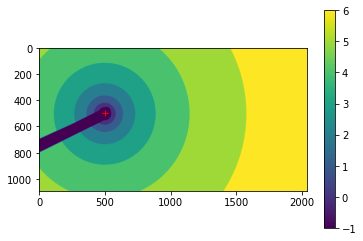

In [11]:
DLS_MI = MI.MIfile(os.path.join(froot, 'MI_DLS.raw'))
DLS_times = iof.LoadImageTimes(os.path.join(froot, 'MI_DLS_imgTimes.dat'), usecols=3, skiprows=1)
DLS_pxmask = MI.ReadBinary(os.path.join(froot, 'MI_DLS_pxmask.raw'), DLS_MI.ImageShape(), 'B')
DLS_ROIs = [np.geomspace(50, 1800, 8), None]
DLS_analyzer = LS.SALS(DLS_MI, centerPos=[500, 500], ROIslices=DLS_ROIs, maskRaw=DLS_pxmask, imgTimes=DLS_times)

print(DLS_analyzer)
plt.imshow(DLS_analyzer.ROIs)
plt.plot(*DLS_analyzer.centerPos, 'r+')
plt.colorbar()

In [12]:
%%time
DLS_analyzer.doDLS(os.path.join(froot, 'out'), lagtimes=[1, 2, 4, 10, 20, 30, 40])

INFO:root:ROIproc.doDLS Analysis started! Input data is 50 images (50 times, 1 exposure times)
INFO:root:Analysis will resolve 7 ROIs and DLS will be performed on 50 reference times and 8 lagtimes. Output will be saved in folder ..\SALS_test\out
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (50, 1, 7)), Iavg data (shape: (50, 7)), exptime data (shape: (50, 7)), buffer images (shape (50, 1088, 2040))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 50 time points, 8 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 50, 1] (50 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/7 (d1) completed
INFO:root:Lagtime 2/7 (d2) completed
INFO:root:Lagtime 3/7 (d4) completed
INFO:root:Lagtime 4/7 (d10) completed
INFO:root:Lagtime 5/7 (d20) completed
INFO:root:Lagtime 6/7 (d30) completed
INFO:root:Lagtime 7/7 (d40) completed
INFO:root:Now saving RO

Wall time: 15.2 s


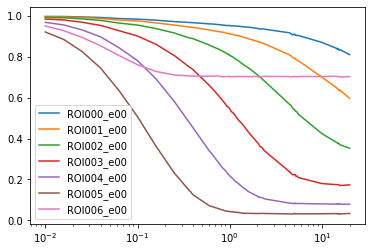

In [13]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(os.path.join(froot, 'out'))
fig, ax = plt.subplots()
for i in range(len(g2m1_data)):
    ax.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
ax.set_xscale('log')
ax.legend()

### Initialization from config file

As for ```ROIproc``` class, DLS analysis saves analysis parameters in a configuration ```*.ini``` file, which has all the entries of the one generated by ```ROIproc.doDLS```, but has a ```[SALS]``` section with ```SALS```-specific parameters. This file can be used to reload the ```SALS``` object by calling

```python
SALS_analyzer = LS.LoadFromConfig(ConfigFile, runAnalysis=True)
```

DEBUG:root:Loading config file ..\SALS_test\out\SALSconfig.ini (8 sections, 40 keys)
DEBUG:root:Config.LoadConfig() assuming that input is of Config type (8 sections)
INFO:root:ROIproc.LoadFromConfig reading configuration from Config object (8 sections) -- Root folder: C:\Users\steaime\Documents\Codes\DSH\SALS_test\out -- version 2.0, generated by SALS.doDLS on 06/06/2023, 12:09:55
DEBUG:root:MIfile object created with filename C:\Users\steaime\Documents\Codes\DSH\SALS_test\MI_DLS.raw
DEBUG:root:Now loading MIfile metadata (dict with 8 keys)
DEBUG:root:Appending input dictionary to section MIfile
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile', 'settings']
DEBUG:root:ROIproc.LoadFromConfig loading MIfile C:\Users\steaime\Documents\Codes\DSH\SALS_test\MI_DLS.raw (metadata: {'hdr_len': '0', 'px_format': 'B', 'fps': '10', 'px_size': '1', 'shape': '[50, 1088, 2040]', 'comments': 'sample multi image MIfile', 'is_stack': 'False', 'filename': 'C:\\User


|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (C:\Users\steaime\Documents\Codes\DSH\SALS_test\MI_DLS.raw), 50 images
| Center position : [500, 500]
| ROIs            : 7 (7 valid, 0 empty)
| Exposure times  : 1, from 1.0 to 1.0
|-----------------+---------------


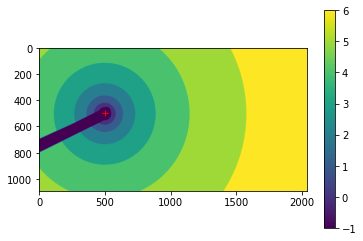

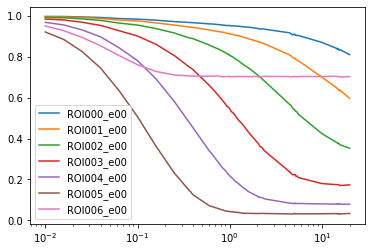

In [14]:
SALS_reload = LS.LoadFromConfig(os.path.join(froot, 'out', 'SALSconfig.ini'))

print(SALS_reload)
plt.imshow(SALS_reload.ROIs)
plt.plot(*SALS_reload.centerPos, 'r+')
plt.colorbar()

g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(os.path.join(froot, 'out', 'reproc'))
fig, ax = plt.subplots()
for i in range(len(g2m1_data)):
    ax.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
ax.set_xscale('log')
ax.legend()